# Big Data Project
# Learning Mixture of Gaussians with Streaming Data

## 1. Abstract
In this project, we explore a theoretical paper published in Neurips2017 Conference titled **Learning Mixture of Gaussians with Streaming Data** by doing some experimental tests on the performance of the algorithm.  You can find the original paper [here](https://papers.nips.cc/paper/7238-learning-mixture-of-gaussians-with-streaming-data).<br>
The authors of the paper proposed an algorithm with a theoretical guarantee for the problem of **clustering the streaming data points where data points come from a Mixture of Gaussian Distribution**. In particular, they showed that with high probability, the algorithm eventually finds (/learns) the mixture of Gaussians accurately. Moreover, they showed that the learning rate is near-optimal. Meaning that in each step, the error decreases optimally. Note that, as the problem of learning the mixture of Gaussian is NP-Hard, they used a simplification assumption for the data to make the problem tractable. The simplification assumption they used is that data comes from a mixture of **well-separated** Gaussians. (i.e. the centers of any two clusters are far enough so that the algorithm can decide computationally easily whether the point belongs to the first cluster or the second one.)<br> Although the assumption allows them to have a good performance for this problem, one question might arise:
Is the analysis of the paper tight? 
<br> 
One way to find an answer to this question is to test the algorithm's performance by running some experimental tests. Of course, the experimental tests just provide evidence and they are not proof. <br>



## 2. Project Outline
In the following, we will first give a bit explanation about the general setup and data distribution in the first section. Then we explain the theorems about the performance of the algorithm. Finally, we test the algorithm performance by generating data from the mixture of Gaussian Distribution and run our implementation of the paper's algorithm <br>

## 3. Setup 
### 3.1. Data Distribution

Data is drawn from a mixture of a mixture of k spherical Gaussians distributions, <br>
i.e. for all $i = 1,2,...,k$:
$$ x^t {\sim} \sum_{i} w_i \mathcal{N}(\mu_i^*, \sigma^2 I) , \sigma_i^* \in \mathcal{R}^d  $$ 

where $\mu_i^*$ is the mean of the i-th mixture component (i-th cluster), mixture weights $w_i \geq 0$, and
$\sum_i wi = 1$. <br>
For simplicity, we assumed all $\sigma_i=\sigma$ are the same. But the algorithm doesn't require this assumption. 

### 3.2. Seperation Assumption
As we stated earlier, the paper used a simplification assumption for the data. In particular, any two centers $i , j$ should be far away from each other at least $C \sigma $ i.e.:
$$ ||\mu_i^* - \mu_j^*|| \geq C \sigma $$

We will explain more about the constant C in the next sections.



### 3.3 Space Overview
100 points drawn from the distribution are depicted here. (note that we have shown a 2-d subspace from the original d-dimensional space of data points. <br>
You can see there are k clusters.

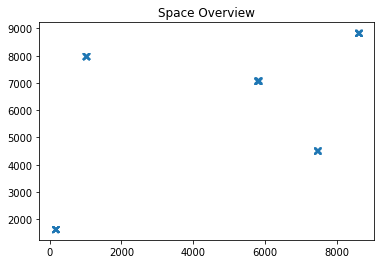

In [3]:
temp = generator.generate_samples(100)
plt.plot(temp[0, :], temp[1,:], 'x')
plt.title("Space Overview")
plt.show()

## 4. Algorithm Overview
The algorithm consists of two parts: <br>
1 . Algorithm1 (initialization algorithm) <br>
2 . Algorithm2: (a) Streaming using Lloyd's Heuristic, (b) Expectation Maximization (i.e.Soft version of Lloyd's Heuristic) <br>

Note that Expectation Maximization part is available in another file named "EM". <br>
### 4.1 Initialization Algorithm
In the initialization part, we try to find k initial centers for k clusters. To do so, we first use SVD-style operations to project d dimensional data points into a k-dimensional space. These operations project will de-noise the data, making it easy for the algorithm to identify all k distinct clusters from few data points. After we find k clusters centers in the projected space, we project them to the original d-dimensional space. This way, we have a good initialization for the k centers.<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from scipy import linalg
import random
from sklearn import neighbors
import sklearn.metrics.pairwise
from scipy.sparse import csgraph
import random
import pandas as pd


d = 10
k = 5
scaler = 10000
sigma = 100
num_of_samples = int(d*d*d*k*k*k*np.log(d*k))  #N0
w = np.ones(k) / k

## For initializatoin, we need C to be at least OMEGA((klogk)^1/4). So:
C = 10*((k*np.log(k))**(1/4))
C2 = (np.log(k)**(1/2))
##TODO: Change max to min but make sure that you ignore the diagonal values as they are zeros and they should be ignored. 
def generate_distant_means(dimension, C, std):
    mu = np.random.rand(d, k) * scaler
    dist = sklearn.metrics.pairwise.euclidean_distances(mu.T)
    dist = dist + np.identity(k, dtype = float) * 2 * C * sigma
    min_dist = np.min(dist)
    while (min_dist < C * sigma):
        print ("close_initial_points_occured, start again")
        mu = np.random.rand(d, k) * scaler
        dist = sklearn.metrics.pairwise.euclidean_distances(mu.T)
        dist = dist + np.identity(k, dtype = float)   * 2 * C * sigma
        min_dist = np.min(dist)
    return mu

mu = generate_distant_means(d, C, sigma)
print ("True Centers for Clusters")

tmp = pd.DataFrame(mu)
tmp

True Centers for Clusters


,0,1,2,3,4
0,1006.573560,7457.903141,8607.361205,5805.062752,159.473022
1,7981.089236,4519.639663,8843.143067,7082.612751,1638.453342
2,1786.589980,7512.222316,4686.177980,1062.615207,6604.511910
3,3298.659779,8089.362560,6149.617684,4718.901034,7559.245778
4,8864.726130,5712.461236,1803.188495,7849.071028,7154.246706
5,7637.138501,6373.934348,3263.415539,1354.105588,2977.484326
6,6208.651794,2407.470493,1071.618747,5643.999592,3806.159423
7,2173.689721,828.673876,1893.492336,2113.814978,2271.450202
8,5882.354979,1509.902750,6242.963681,8404.339237,9478.986709
9,9055.694116,9003.731212,6530.270935,1714.366744,2276.888733


Sample Generator Class

In [2]:
class SampleGenerator:
    def __init__(self, weights, mu, sigma, d):
        self.weights = weights
        self.mu = mu
        self.sigma=sigma
        self.d = d
    
    def draw_a_sample(self):
        rand = random.uniform(0,1)
        for i in range(len(self.weights)):
            rand -= self.weights[i]
            if (rand <=0):
                return np.random.multivariate_normal(self.mu[:,i], self.sigma * np.identity(self.d), 1).T
    
    def generate_samples(self, sample_size):
        samples = []
        for i in range(sample_size):
            if len(samples) == 0:
                samples = self.draw_a_sample()
            else:
                samples = np.append(samples, self.draw_a_sample(), axis=1)
        return samples

generator = SampleGenerator(w, mu, sigma, d)

#### 4.1.1 Finding k-dimensional subspace using Streaming PCA method
In this part, we are going to find a k dimensional space to reduce the noise of each cluster. This way, all points from a single clusters will become closer to each other, allowing us to use Nearest Neighbor Graph to identify each cluster easily. 

In [4]:
N0 = num_of_samples

S = np.zeros((d, d))
k_2 = int(10 * k * np.log(k))
B = int(d * np.log(d))
U = ortho_group.rvs(dim=d)[:, :k]  # Choosing k orthonormal vectors in Rd space

for t in range(N0 - k_2):
    if t % B == B - 1:
        Q, R = linalg.qr(np.matmul(S, U))
        U = Q
        S = np.zeros((d, d))
    reshaped_sample = generator.draw_a_sample().reshape(-1, 1)
    S = S + np.matmul(reshaped_sample, reshaped_sample.T)

#### 4.1.2 Using Nearest Neighbor to find all k clusters
First, we project points to the k-dimensional space to reduce the noise, then using each point as a node, we build a nearest neighbor graph. Each connected component in the graph would represent a cluster. 

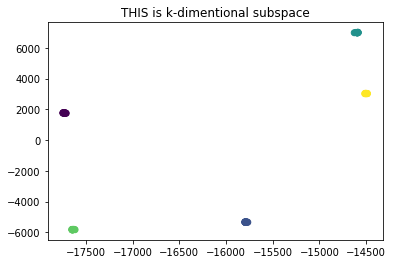

In [5]:
X0 = generator.generate_samples(k_2)
save_U = U
U = U[:, 0:k]
components = np.matmul(U.T, X0)
adj = neighbors.kneighbors_graph(np.transpose(components), 3)
n_components, labels = csgraph.connected_components(adj)

fig, ax = plt.subplots()
ax.scatter(components[0], components[1], c=labels)
plt.title("THIS is k-dimentional subspace")
plt.show()

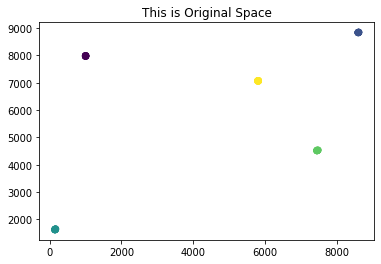

In [6]:
components = np.matmul(U, components)
fig, ax = plt.subplots()
ax.scatter(components[0], components[1], c=labels)
plt.title("This is Original Space")
plt.show()

In [7]:
components_mean = np.zeros((k, d))
components_by_labels = []
for c in range(k):
    list_of_indices = np.where(labels == c)[0]
    components_mean[c] = np.mean(components[:, list_of_indices], axis=1)
    
print("Components mean:")
pd.DataFrame(components_mean.T)

Components mean:


,0,1,2,3,4
0,1004.659735,8602.688447,156.998482,7457.114878,5810.833626
1,7981.449254,8842.145440,1632.891263,4523.029546,7070.616973
2,1790.712167,4682.362683,6602.861160,7512.045539,1061.278888
3,3296.125969,6153.697604,7558.724763,8092.409179,4712.346784
4,8863.349343,1806.231879,7152.189040,5715.178904,7845.894733
5,7628.245490,3258.963132,2980.991991,6375.568134,1361.207542
6,6215.085481,1067.861391,3807.590765,2404.595059,5642.911509
7,2169.924317,1889.896869,2275.113901,832.385092,2119.977969
8,5885.804747,6239.186480,9477.207032,1509.366177,8414.359976
9,9054.406525,6531.609386,2277.226207,9008.111500,1717.347722


In [8]:
print ("TRUE centers")
pd.DataFrame(mu)

TRUE centers


,0,1,2,3,4
0,1006.573560,7457.903141,8607.361205,5805.062752,159.473022
1,7981.089236,4519.639663,8843.143067,7082.612751,1638.453342
2,1786.589980,7512.222316,4686.177980,1062.615207,6604.511910
3,3298.659779,8089.362560,6149.617684,4718.901034,7559.245778
4,8864.726130,5712.461236,1803.188495,7849.071028,7154.246706
5,7637.138501,6373.934348,3263.415539,1354.105588,2977.484326
6,6208.651794,2407.470493,1071.618747,5643.999592,3806.159423
7,2173.689721,828.673876,1893.492336,2113.814978,2271.450202
8,5882.354979,1509.902750,6242.963681,8404.339237,9478.986709
9,9055.694116,9003.731212,6530.270935,1714.366744,2276.888733


#### 4.1.3 Thoerem 3


As we know in the **Theorem 3** of the paper, 
if each two centers have enough seperations, $\Omega (k \log k )^{1/4}$,<br>
then with high probability $1 - \dfrac{1}{poly(k)}$, the distance between TRUE center and algorithm's output can be bounded by<br>
$$|| \mu_i^0 - \mu_i^*|| \leq \dfrac{C}{20}\sigma$$

#### 4.1.4 Verifying Theorem 3: Comparision Between "Alg centers output" and "TRUE centeres"

In [9]:
def distance_calculator(mu, mu_t):
    comparision_matrix = sklearn.metrics.pairwise.euclidean_distances(mu.T, mu_t.T)
    distance_vector = np.min(comparision_matrix, axis=0)
    distance_sum = np.sum(np.min(comparision_matrix, axis=0))

    return distance_sum, distance_vector

In [10]:
distance_sum, distance_vector = distance_calculator(mu, components_mean.T)

DF = pd.DataFrame(distance_vector)
DF.columns = ["Distance"]
print ("Distance between each cluster center and algorithm's output for that center:")
print(DF)

print("Sum of distances:")
print(distance_sum)

Distance between each cluster center and algorithm's output for that center:
    Distance
0  13.315987
1  11.234860
2   8.680253
3   8.543820
4  20.759095
Sum of distances:
62.53401504530203


In [11]:
theorem3_bound= C*sigma/20

print ("Theorem 3 Bound: C/20 * sigma")
theorem3_bound

Theorem 3 Bound: C/20 * sigma


8.421337295817725

As you can see, the TRUE MEANS are very close to initial algorithm's output as desired. <br>

### 4.2 Streaming Clustering (using Lloyd Heuristic)

In this part, we are going to use the Lloyd Heuristic for clustering. Uppon the arrival of each data point, we firstly assign it to its closest center and then update that center.

In [12]:
from numpy import linalg as LA
import copy

mu01 = components_mean.T


def streaming_kmeans(n, input_mu, num_of_logs):
    mu0 = copy.deepcopy(input_mu)
    distance_log = []
    eta = 3 * k * (np.log2(3 * n)) / n
    cut = int(n / num_of_logs)
    for t in range(n):
        if t % cut == 0:
            d, _ = distance_calculator(mu, mu0)
            distance_log.append(d)
        x = generator.draw_a_sample()

        dis = LA.norm((x - mu0), axis=0)
        i = np.argmin(dis)
        x = x.reshape(-1)
        mu0[:, i] = np.multiply((1 - eta), mu0[:, i]) + np.multiply(eta, x)
    return mu0, distance_log

#### 4.2.1 Theroem 1
Intuitively, this theorem upper bounds the error when we have seen enough data. <br>

Let $xt, 1 \leq t \leq N + N_0$ be generated using a mixture of Gaussians  with wi = 1/k,
for all i,  Let $N_0, N \geq  O(1)k^3d^3 \log d $ and $ C \geq \Omega {(k\log k)^{1/4}}$. Then, the algorithm's output satifies the following error bound:

$$ \mathbb{E}(|| \mu^0 - \mu^* ||^2 ) \leq \dfrac{\max_i  ||\mu_i^* ||^2 }{N^{\Omega(1)}} + O(k^3)(\sigma^2\dfrac{d\log N}{N} + \exp (-C^2/8)(c^2+k)\sigma^2) $$

In the following, we will verify theorem 1 experimentally.

In [13]:
def theorem_1(mu, N, sigma, K, C, d):
    return (np.max(LA.norm(mu,axis=0)) / N) + (K**3 * (sigma**2 * d * np.log(N) / N) + np.exp(-C**2 / 8) * (C**2 + K)* sigma**2)

In [14]:
num_of_logs = 1000

run_count = 10
error_matrix = np.zeros((run_count, num_of_logs))
Ns = []
n = 2*int(d*d*d*k*k*k*np.log(d*k))
for run in range(run_count):
    mu_t, distance_log = streaming_kmeans(n, mu01, num_of_logs)
    error_matrix[run] = distance_log[:num_of_logs]
df=pd.DataFrame(error_matrix)

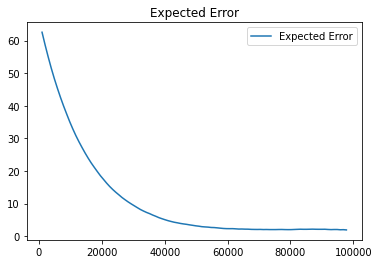

In [15]:
mean_error = np.mean(error_matrix, axis=0)
diagram_cut = 100

theorem_1_log = []
Ns = []
for i in range(num_of_logs):
    cut = int(n / num_of_logs)
    theorem_1_log.append(theorem_1(mu, cut * (i+1), sigma, k, C, d))
    Ns.append(cut * (i+1))
    
p1, =plt.plot(Ns[:diagram_cut], mean_error[:diagram_cut], label='Expected Error')
plt.legend(loc='best')
plt.title('Expected Error')
plt.show()

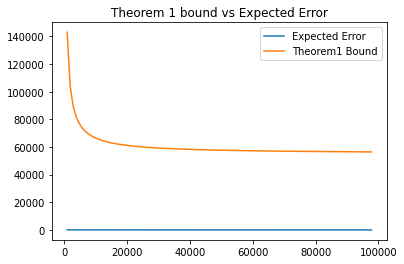

In [16]:
p1, =plt.plot(Ns[:diagram_cut], mean_error[:diagram_cut], label='Expected Error')
p2, =plt.plot(Ns[:diagram_cut], theorem_1_log[:diagram_cut], label='Theorem1 Bound')
plt.legend(loc='best')
plt.title('Theorem 1 bound vs Expected Error')
plt.show()

[]

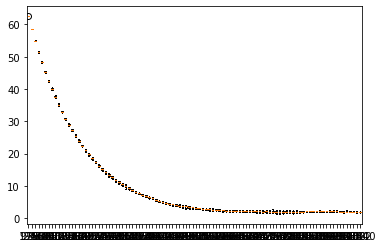

In [17]:
boxplot_dict = {}

for i in range(diagram_cut):
    boxplot_dict[cut * (i+1)] = [np.mean(error_matrix[:, i]), np.min(error_matrix[:, i]), np.max(error_matrix[:, i]), ]

fig, ax = plt.subplots()
ax.boxplot(boxplot_dict.values())
ax.set_xticklabels(boxplot_dict.keys())
plt.plot()

#### 4.2.2 Theorem 2
The streaming part of the algorithm works even when the data seperation C is much less. (when $ C \geq \Omega (\log k)^{1/2} $) <br>
In this part, we will verify it experimentally in the following cell. 

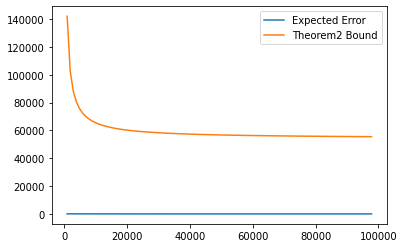

In [18]:
theorem_2_log = []
for i in range(num_of_logs):
    cut = int(n / num_of_logs)
    theorem_2_log.append(theorem_1(mu, cut * (i+1), sigma, k, C2, d))
    
p1, =plt.plot(Ns[:diagram_cut], mean_error[:diagram_cut], label='Expected Error')
p2, =plt.plot(Ns[:diagram_cut], theorem_2_log[:diagram_cut], label='Theorem2 Bound')
plt.legend(loc='best')
plt.show()